In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings('ignore')

In [3]:
o_data  = pd.read_csv('data/data.csv', header=0)
test_data = o_data[o_data['shot_made_flag'].isnull()]

test_data.info()
train_data = o_data[~o_data['shot_made_flag'].isnull()]
train_data.info()
full_data = [train_data, test_data]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 30693
Data columns (total 25 columns):
action_type           5000 non-null object
combined_shot_type    5000 non-null object
game_event_id         5000 non-null int64
game_id               5000 non-null int64
lat                   5000 non-null float64
loc_x                 5000 non-null int64
loc_y                 5000 non-null int64
lon                   5000 non-null float64
minutes_remaining     5000 non-null int64
period                5000 non-null int64
playoffs              5000 non-null int64
season                5000 non-null object
seconds_remaining     5000 non-null int64
shot_distance         5000 non-null int64
shot_made_flag        0 non-null float64
shot_type             5000 non-null object
shot_zone_area        5000 non-null object
shot_zone_basic       5000 non-null object
shot_zone_range       5000 non-null object
team_id               5000 non-null int64
team_name             5000 non-null object

In [4]:
shot_ids = full_data[1]['shot_id']
shot_ids.head()

0      1
7      8
16    17
19    20
32    33
Name: shot_id, dtype: int64

## Feature Engineering

### 投篮类型

        shot_type  shot_made_flag
0  2PT Field Goal           20285
1  3PT Field Goal            5412


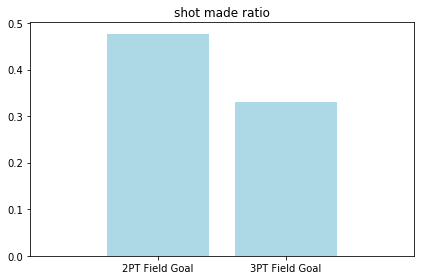

In [5]:
def plotBar(shot_aau, title):
    cols = shot_aau.columns
    plt.title(title)
    plt.bar(range(shot_aau.shape[0]), shot_aau[cols[1]],\
        color='lightblue',align='center', width=0.8)
    plt.xticks(range(shot_aau.shape[0]),shot_aau[cols[0]])#, rotation=90)
    plt.xlim([-1, shot_aau.shape[0]])
    plt.tight_layout()
    plt.show()
def plotGroupRatioBar(feature):
    g = train_data[[feature, 'shot_made_flag']].groupby(feature, as_index=False)
    print(g.count())
    plotBar(g.mean().head(40), 'shot made ratio')
#     print(shot_type_g)
plotGroupRatioBar('shot_type')

### 投篮距离, 影响较大的因素

    shot_distance  shot_made_flag
0               0            4608
1               1             522
2               2             483
3               3             319
4               4             317
5               5             444
6               6             557
7               7             603
8               8             568
9               9             528
10             10             588
11             11             602
12             12             644
13             13             786
14             14             894
15             15             972
16             16            1165
17             17            1225
18             18            1195
19             19            1131
20             20             993
21             21             671
22             22             571
23             23             493
24             24            1263
25             25            1631
26             26            1060
27             27             450
28            

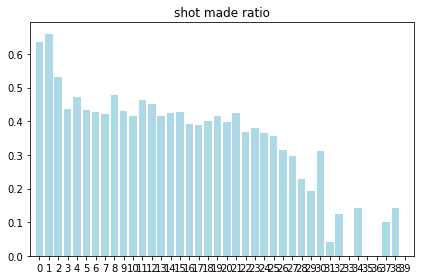

In [6]:
plotGroupRatioBar('shot_distance')

### 投篮类型.粒度太细,某些类型的投篮次数只有个位数

In [7]:
# action_type_group = train_data[['action_type', 'shot_made_flag']].groupby('action_type', as_index=False)
# action_type_group.describe()

  combined_shot_type  shot_made_flag
0          Bank Shot             120
1               Dunk            1056
2          Hook Shot             127
3          Jump Shot           19710
4              Layup            4532
5           Tip Shot             152


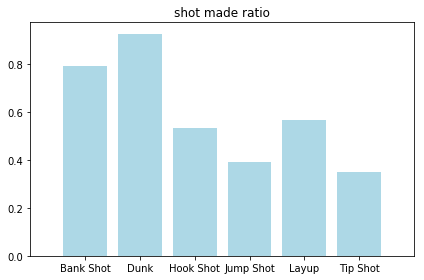

In [8]:
plotGroupRatioBar('combined_shot_type')

          shot_zone_area  shot_made_flag
0         Back Court(BC)              72
1              Center(C)           11289
2   Left Side Center(LC)            3364
3           Left Side(L)            3132
4  Right Side Center(RC)            3981
5          Right Side(R)            3859


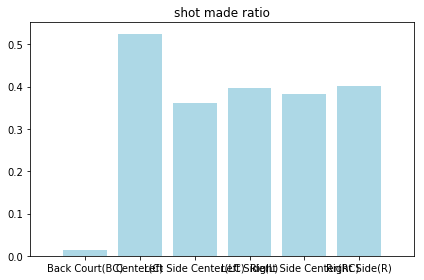

In [9]:
plotGroupRatioBar('shot_zone_area')

         shot_zone_basic  shot_made_flag
0      Above the Break 3            4720
1              Backcourt              60
2  In The Paint (Non-RA)            3880
3          Left Corner 3             240
4              Mid-Range           10532
5        Restricted Area            5932
6         Right Corner 3             333


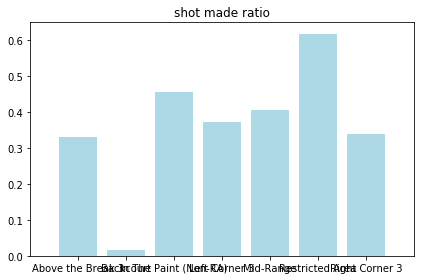

In [10]:
plotGroupRatioBar('shot_zone_basic')

   opponent  shot_made_flag
0       ATL             438
1       BKN              45
2       BOS             783
3       CHA             500
4       CHI             516
5       CLE             514
6       DAL            1033
7       DEN            1352
8       DET             587
9       GSW            1143
10      HOU            1399
11      IND             626
12      LAC            1074
13      MEM             871
14      MIA             517
15      MIL             507
16      MIN            1219
17      NJN             422
18      NOH             475
19      NOP             287
20      NYK             566
21      OKC             561
22      ORL             604
23      PHI             603
24      PHX            1535
25      POR            1292
26      SAC            1397
27      SAS            1638
28      SEA             694
29      TOR             556
30      UTA            1238
31      VAN             204
32      WAS             501


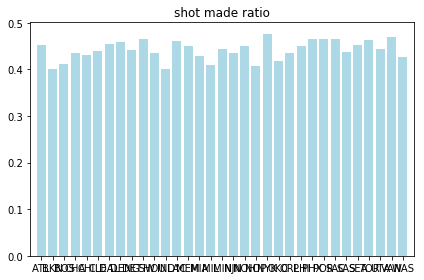

In [11]:
plotGroupRatioBar('opponent')

除了后面几个赛季,其他赛季命中率相差都不大

     season  shot_made_flag
0   1996-97             383
1   1997-98             810
2   1998-99             765
3   1999-00            1312
4   2000-01            1575
5   2001-02            1708
6   2002-03            1852
7   2003-04            1371
8   2004-05            1127
9   2005-06            1924
10  2006-07            1579
11  2007-08            1819
12  2008-09            1851
13  2009-10            1772
14  2010-11            1521
15  2011-12            1416
16  2012-13            1328
17  2013-14              59
18  2014-15             593
19  2015-16             932


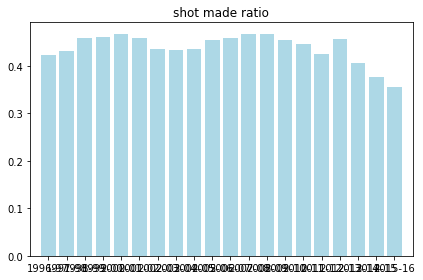

In [12]:
plotGroupRatioBar('season')

In [13]:
def get_host_or_guest(s):
    return 1 if '@' in s else 0
for dataset in full_data:
    dataset['is_guest'] = dataset['matchup'].apply(get_host_or_guest)
    dataset['shot_type'] = dataset['shot_type'].map({'2PT Field Goal':0, '3PT Field Goal': 1})
#     ohe = OneHotEncoder(categorical_features=[2, 3, 5, 6, 7])
#     dataset = ohe.fit_transform(dataset).toarray()

### 主客场

   is_guest  shot_made_flag
0         0           12485
1         1           13212


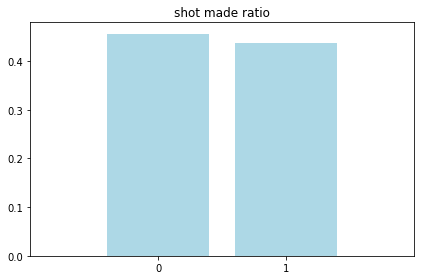

In [14]:
plotGroupRatioBar('is_guest')

# 是否是季后赛

   playoffs  shot_made_flag
0         0           21939
1         1            3758


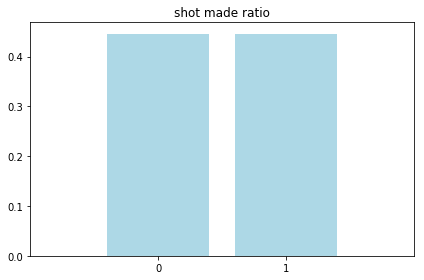

In [15]:
plotGroupRatioBar('playoffs')

   period  shot_made_flag
0       1            6700
1       2            5635
2       3            7002
3       4            6043
4       5             280
5       6              30
6       7               7


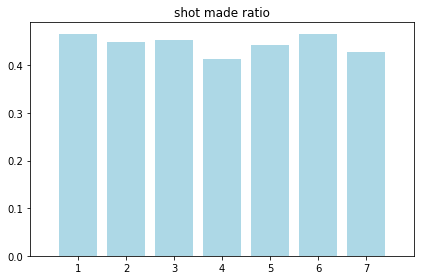

In [16]:
#第几节
plotGroupRatioBar('period')

In [17]:
selected_f = ['shot_type', 'shot_distance','season', 'opponent', 'is_guest','shot_zone_area', 'shot_zone_basic', 'combined_shot_type', 'playoffs', 'period']
y = train_data['shot_made_flag']
train_data = train_data[selected_f]
test_data = test_data[selected_f]

In [18]:
class myNb:
    def __init__(self):
        self.cProb = {}
        self.cCondProb = {}
    def fit(self, X_train, y_train):
        import numpy as np

        # 生还与否的概率
        t = len(y_train)
        # 生还和死者总数
        cNumber = {}
        cValues = np.unique(y_train)
        #类概率
        for cv in cValues:
            cNumber[cv] = (y_train == cv).sum()
            self.cProb[cv] = cNumber[cv] / t
        #求类条件概率
        for col in X_train:
            if col not in self.cCondProb:
                self.cCondProb[col] = {}
            for cv in self.cProb:
                if cv not in self.cCondProb[col]:
                    self.cCondProb[col][cv] = {}
                for fv in np.unique(X_train[col]):
                    self.cCondProb[col][cv][fv] = ((X_train[col] == fv) & (y_train == cv)).sum() / cNumber[cv]
                    if self.cCondProb[col][cv][fv] == 0:
                        self.cCondProb[col][cv][fv] = 1e-10

    def predict_proba(self, X_test):
        y_pred = []
        P = [0] * len(self.cProb)
        Plog = [0] * len(self.cProb)
        for cv in range(0, len(self.cProb)):
            Plog[cv] = np.log(self.cProb[cv])
        for i in X_test.index:
            for cv in range(0, len(self.cProb)):
                P[cv] = Plog[cv]
                for col in X_test:
#                     print(i, col)
                    if self.cCondProb[col][cv][X_test.loc[i][col]] == 0:
                        print(i, col)
                    P[cv] += np.log(self.cCondProb[col][cv][X_test.loc[i][col]])
            P = np.exp(P)
            P = P / sum(P)
#             print(i,P)
#             y_pred.append(max(P, key=P.get))
#             np.append(y_pred, [P])
            y_pred.append(P.tolist())
        return np.array(y_pred)

    # def predict_proba(self, X_test):

In [19]:
train_data.index
# test_data.index

Int64Index([    1,     2,     3,     4,     5,     6,     8,     9,    10,
               11,
            ...
            30685, 30687, 30688, 30689, 30690, 30691, 30692, 30694, 30695,
            30696],
           dtype='int64', length=25697)

# 朴素贝叶斯方法

In [20]:
nb = myNb()
nb.fit(train_data, y)

In [22]:
start = 10000
offset = 1000
y_pred = nb.predict_proba(train_data.iloc[start:start+offset])
# print(y_pred)
print('log loss: %.2f' % log_loss(y[start:start+offset].values, y_pred))
y_pred_class = (y_pred.T[0]<y_pred.T[1]) * 1
print('Accuracy: %.2f' % accuracy_score(y[start:start+offset].values, y_pred_class))

log loss: 0.76
Accuracy: 0.63


In [23]:
import time
def outPutFile(shot_ids, result, name):
    submission = pd.DataFrame({'shot_id': shot_ids, 'shot_made_flag':result})
    submission.to_csv(name + str(time.time()) +'.csv', index=False)

In [24]:
myNB_result = nb.predict_proba(test_data)
outPutFile(shot_ids, myNB_result.T[1], 'MYNB')



print(y_pred[0:10])
y_pred_alter = y_pred - (y_pred-0.5) * 0.5
print(y_pred_alter[0:10])
print('log loss: %.2f' % log_loss(y[start:start+offset].values, y_pred_alter))

[[ 0.71082605  0.28917395]
 [ 0.01138356  0.98861644]
 [ 0.0111746   0.9888254 ]
 [ 0.70593913  0.29406087]
 [ 0.71358517  0.28641483]
 [ 0.67642822  0.32357178]
 [ 0.88299774  0.11700226]
 [ 0.70695921  0.29304079]
 [ 0.69430669  0.30569331]
 [ 0.63106295  0.36893705]]
[[ 0.60541302  0.39458698]
 [ 0.25569178  0.74430822]
 [ 0.2555873   0.7444127 ]
 [ 0.60296956  0.39703044]
 [ 0.60679258  0.39320742]
 [ 0.58821411  0.41178589]
 [ 0.69149887  0.30850113]
 [ 0.6034796   0.3965204 ]
 [ 0.59715335  0.40284665]
 [ 0.56553147  0.43446853]]
log loss: 0.66


In [25]:
# class_le = LabelEncoder()
    
train_data = pd.get_dummies(train_data)
test_data = pd.get_dummies(test_data)


X=train_data.values
y=y.values

In [62]:
print(train_data.columns)

Index(['shot_type', 'shot_distance', 'is_guest', 'playoffs', 'period',
       'season_1996-97', 'season_1997-98', 'season_1998-99', 'season_1999-00',
       'season_2000-01', 'season_2001-02', 'season_2002-03', 'season_2003-04',
       'season_2004-05', 'season_2005-06', 'season_2006-07', 'season_2007-08',
       'season_2008-09', 'season_2009-10', 'season_2010-11', 'season_2011-12',
       'season_2012-13', 'season_2013-14', 'season_2014-15', 'season_2015-16',
       'opponent_ATL', 'opponent_BKN', 'opponent_BOS', 'opponent_CHA',
       'opponent_CHI', 'opponent_CLE', 'opponent_DAL', 'opponent_DEN',
       'opponent_DET', 'opponent_GSW', 'opponent_HOU', 'opponent_IND',
       'opponent_LAC', 'opponent_MEM', 'opponent_MIA', 'opponent_MIL',
       'opponent_MIN', 'opponent_NJN', 'opponent_NOH', 'opponent_NOP',
       'opponent_NYK', 'opponent_OKC', 'opponent_ORL', 'opponent_PHI',
       'opponent_PHX', 'opponent_POR', 'opponent_SAC', 'opponent_SAS',
       'opponent_SEA', 'opponent_TOR'

In [ ]:
def getScore(clf, X, y):
    acc = 0
    logloss = 0
    n_splits = 10
    sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.1, random_state=0)
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        train_predictions = clf.predict(X_test)
        acc += accuracy_score(y_test, train_predictions)
        train_predictions_proba = clf.predict_proba(X_test)
#         print(train_predictions_proba[0:100])
        logloss += log_loss(y_test, train_predictions_proba)
    acc /= n_splits
    logloss /= n_splits
    return acc, logloss
import sys;print('Python %s on %s' % (sys.version, sys.platform))
sys.path.extend(['/home/wangbo/PycharmProjects/kaggle'])

In [34]:
import LogReg
import importlib
# importlib.reload(LogReg)
time1 = time.time()
clf = LogReg.LogReg(reg=0.1, mini_batches_size = 1000, eta=0.01, max_iter=100)
acc, logloss = getScore(clf, X, y)
print(acc, logloss)
time2 = time.time()
print("my log reg expend time is: %.2f" % (time2 - time1))
sk_lr = LogisticRegression()
acc, logloss = getScore(sk_lr, X, y)
print(acc, logloss)
time3 = time.time()
print("my log reg expend time is: %.2f" % (time3 - time2))

Python 3.5.2 (default, Nov 17 2016, 17:05:23) 
[GCC 5.4.0 20160609] on linux
0.567821011673 12.7074798642
my log reg expend time is: 8.77
0.613151750973 0.650547827246
my log reg expend time is: 2.07


In [26]:
import tensorflow as tf
x = tf.placeholder(tf.float32, [None, X.shape[1]])
y_ = tf.placeholder(tf.float32, [None])
W = tf.Variable(tf.zeros([X.shape[1]]))
b = tf.Variable(tf.zeros([1]))

y = tf.div(1, tf.exp(-tf.matmul(x, W)))
cross_entropy = tf.reduce_mean(y_ * tf.log(y) + (1 - y_) * tf.log(1 - y))
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)
for _ in range(1000):
    

SyntaxError: unexpected EOF while parsing (<ipython-input-26-33cdf58ec234>, line 10)

In [33]:
import time
time.time()

1504101100.819154

/usr/local/lib/python3.5/dist-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.5/dist-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.5/dist-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.5/dist-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.5/dist-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.5/dist-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.5/dist-packages/sklearn

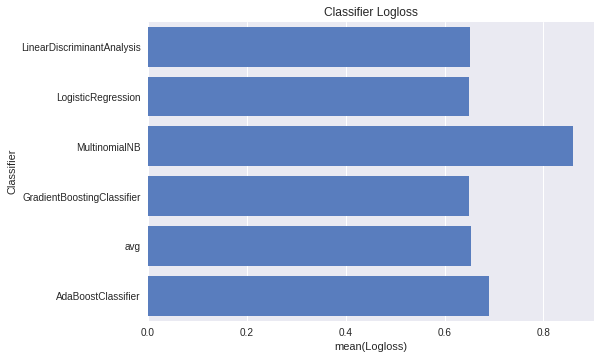

,Classifier,Accuracy,Logloss
0,LinearDiscriminantAnalysis,0.613735,0.651594
0,LogisticRegression,0.613152,0.650548
0,MultinomialNB,0.596732,0.860154
0,GradientBoostingClassifier,0.613969,0.649887
0,avg,0.614786,0.654556
0,AdaBoostClassifier,0.614864,0.690520


In [132]:
# rf = RandomForestClassifier()

import seaborn as sns
from sklearn.ensemble import ExtraTreesClassifier

classifiers = [
#     KNeighborsClassifier(3),
#     SVC(probability=True),
#     DecisionTreeClassifier(),
#     RandomForestClassifier(),
    AdaBoostClassifier(),
#     ExtraTreesClassifier(),
    GradientBoostingClassifier(),
#     GaussianNB(),
    MultinomialNB(),
    LinearDiscriminantAnalysis(),
#     QuadraticDiscriminantAnalysis(),
    LogisticRegression()
]
# classifiers = [rf]
n_splits = 10
sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.1, random_state=0)
acc_dict = {}
log_cols = ["Classifier", "Accuracy", "Logloss"]
log      = pd.DataFrame(columns=log_cols)


for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    avg_pred_proba = np.zeros((len(test_index), 2))
    avg_pred = np.zeros(len(test_index))
    for clf in classifiers:
        name = clf.__class__.__name__
        clf.fit(X_train, y_train)
        train_predictions = clf.predict(X_test)
        acc = accuracy_score(y_test, train_predictions)
        avg_pred += train_predictions
        train_predictions_proba = clf.predict_proba(X_test)
        avg_pred_proba += train_predictions_proba
        logloss = log_loss(y_test, train_predictions_proba)
        if name in acc_dict:
            acc_dict[name] += np.array([acc, logloss])
        else:
            acc_dict[name] = np.array([acc, logloss])
    avg_pred_proba = avg_pred_proba / len(classifiers)
    logloss = log_loss(y_test, avg_pred_proba)
    avg_pred = avg_pred > (len(classifiers) / 2)
    acc = accuracy_score(y_test, avg_pred)
    name = 'avg'
    if name in acc_dict:
        acc_dict[name] += np.array([acc, logloss])
    else:
        acc_dict[name] = np.array([acc, logloss])
            

#平均
for clf in acc_dict:
    acc_dict[clf] = acc_dict[clf] / n_splits
    log_entry = pd.DataFrame([[clf, acc_dict[clf][0], acc_dict[clf][1]]], columns=log_cols)
    log = log.append(log_entry)
    
plt.xlabel('Logloss')
plt.title('Classifier Logloss')

sns.set_color_codes("muted")
sns.barplot(x='Logloss', y='Classifier', data=log[["Classifier", "Logloss"]], color="b")
plt.show()
log

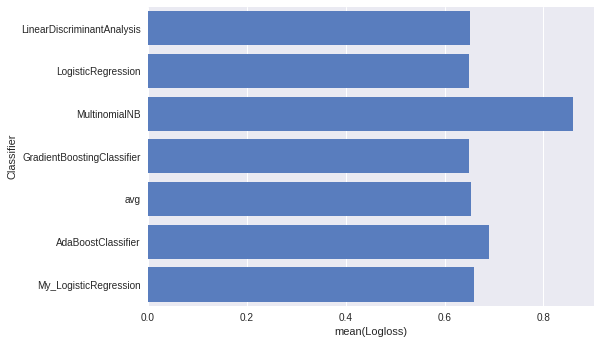

,Classifier,Accuracy,Logloss
0,LinearDiscriminantAnalysis,0.613735,0.651594
0,LogisticRegression,0.613152,0.650548
0,MultinomialNB,0.596732,0.860154
0,GradientBoostingClassifier,0.613969,0.649887
0,avg,0.614786,0.654556
0,AdaBoostClassifier,0.614864,0.690520
0,My_LogisticRegression,0.610506,0.660388


In [163]:
log_entry = pd.DataFrame([["My_LogisticRegression", acc, logloss]], columns=log_cols)
log = log.append(log_entry)
sns.barplot(x='Logloss', y='Classifier', data=log[["Classifier", "Logloss"]], color="b")
plt.show()
log

In [66]:
candidate_classifier = LogisticRegression()
candidate_classifier.fit(X, y)
result = candidate_classifier.predict_proba(test_data.values)

# outPutFile(shot_ids, result.T[1], "LR")

In [67]:
result

array([[ 0.56957688,  0.43042312],
       [ 0.5594357 ,  0.4405643 ],
       [ 0.40898715,  0.59101285],
       ..., 
       [ 0.61699995,  0.38300005],
       [ 0.59591749,  0.40408251],
       [ 0.6850868 ,  0.3149132 ]])

In [80]:
#averaging
avg = None
for candidate_classifier in classifiers:
    candidate_classifier.fit(X, y)
    result = candidate_classifier.predict_proba(test_data.values)
#     print(result)
    if avg is None:
        avg = result
    else:
        avg += result
avg = avg / len(classifiers)

[[ 0.50114003  0.49885997]
 [ 0.50273416  0.49726584]
 [ 0.49797181  0.50202819]
 ..., 
 [ 0.50172155  0.49827845]
 [ 0.50121893  0.49878107]
 [ 0.5040907   0.4959093 ]]
[[ 0.7780259   0.2219741 ]
 [ 0.11479339  0.88520661]
 [ 0.08180603  0.91819397]
 ..., 
 [ 0.50141183  0.49858817]
 [ 0.39819359  0.60180641]
 [ 0.12203397  0.87796603]]


/usr/local/lib/python3.5/dist-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


[[ 0.57485365  0.42514635]
 [ 0.56657696  0.43342304]
 [ 0.40381328  0.59618672]
 ..., 
 [ 0.62079545  0.37920455]
 [ 0.59902599  0.40097401]
 [ 0.69804851  0.30195149]]
[[ 0.56957688  0.43042312]
 [ 0.5594357   0.4405643 ]
 [ 0.40898715  0.59101285]
 ..., 
 [ 0.61699995  0.38300005]
 [ 0.59591749  0.40408251]
 [ 0.6850868   0.3149132 ]]


In [87]:
outPutFile(shot_ids, result.T[1], "AVG")
avg

array([[ 0.60589912,  0.39410088],
       [ 0.43588505,  0.56411495],
       [ 0.34814457,  0.65185543],
       ..., 
       [ 0.5602322 ,  0.4397678 ],
       [ 0.523589  ,  0.476411  ],
       [ 0.50231499,  0.49768501]])

Python 3.5.2 (default, Nov 17 2016, 17:05:23) 
[GCC 5.4.0 20160609] on linux
